In [2]:
using Pkg
Pkg.activate("..")
using OrdinaryDiffEq, Plots, Distributions, EcoFuncSim, LinearAlgebra

N_sp = 100
u0 = ones(N_sp)

u_r = Normal(10,1.0)
r  = rand(u_r,N_sp)

u_a_i = Normal(1,0.1)
a_i  = ones(N_sp)

u_p = Normal(5,0.1)
p  = rand(u_p,N_sp);
# p = zeros(N_sp);

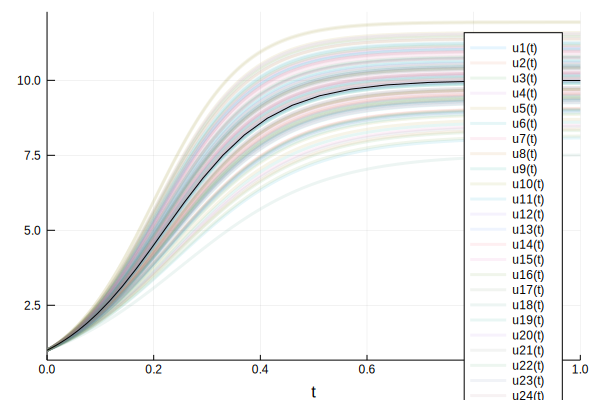

In [3]:
tspan = (0.0,1.0)

function test_logistic(du,u,p,t)
    for i = 1:length(du)
        du[i] = u[i] * (p[i]  - 1*u[i])
    end
end

function logistic_mean(C0,r,t)
    top = r * C0 * exp(r*t)
    bot = C0 * exp(r*t) - C0 + r
    
    return(top/bot)
end

prob = ODEProblem(test_logistic,u0,tspan,r)
sol = solve(prob,Rosenbrock23())
plot(sol,alpha=0.1)
plot!(sol.t,logistic_mean.(1.0,10,sol.t),color=:black)

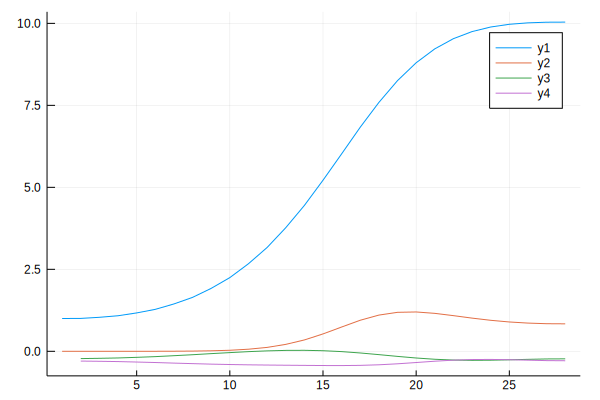

In [4]:
plot(map(mean,sol(sol.t).u))
plot!(map(var,sol(sol.t).u))
plot!(map(skewness,sol(sol.t).u))
plot!(map(kurtosis,sol(sol.t).u))

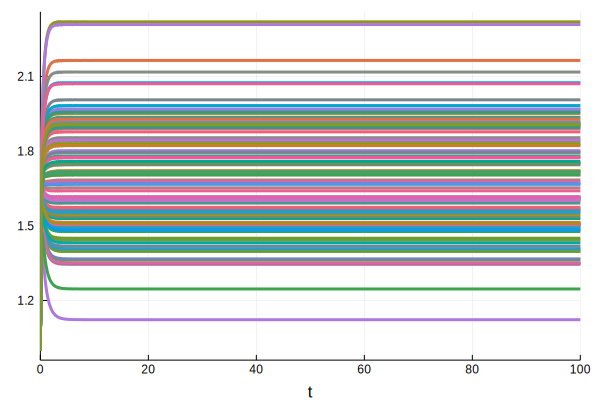

In [2]:
U = r
R = zeros(N_sp)

u_a = Normal(u_p.μ/N_sp,u_p.σ/N_sp)
a = rand(u_a,N_sp,N_sp)
# a[diagind(a)] = a_i
a = Array(Symmetric(a))

P = make_params(U,R,a,intra = false)
sol_real = simulate(u0,P,t_end = 100.0)
plot(sol_real,legend = false)

## Mean Model

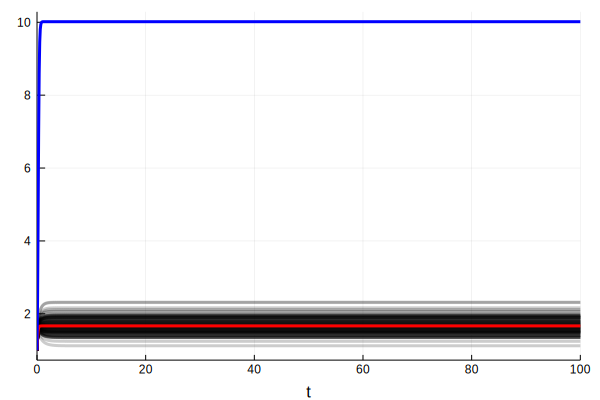

In [5]:
param = [[mean(r),moment(r,2,0)],[mean(a_i),moment(a_i,2,0)],[mean(p),moment(p,2,0)]]
tspan = (0.0,100.0)
function test_mean_app(du,u,p,t)
        du[1] = u[1] * (p[1][1] - u[1] * p[2][1] - u[1] * p[3][1])
end

prob = ODEProblem(test_mean_app,[mean(u0)],tspan,param)
sol_mean_app = solve(prob,Rosenbrock23())

function test_no_mean_app(du,u,p,t)
        du[1] = u[1] * (p[1][1] - u[1] * p[2][1])
end

prob = ODEProblem(test_no_mean_app,[mean(u0)],tspan,param)
sol_no_mean_app = solve(prob,Rosenbrock23())

plot(sol_real,colour="black",alpha=0.2,legend=false)
plot!(sol_mean_app,colour="red")
plot!(sol_no_mean_app,colour="blue")

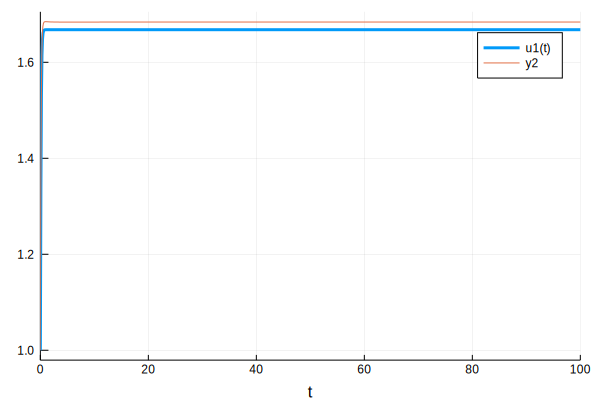

In [6]:
#explicit mean solution

plot(sol_mean_app)
plot!(sol_mean_app.t,mean.(sol_real(sol_mean_app.t).u))

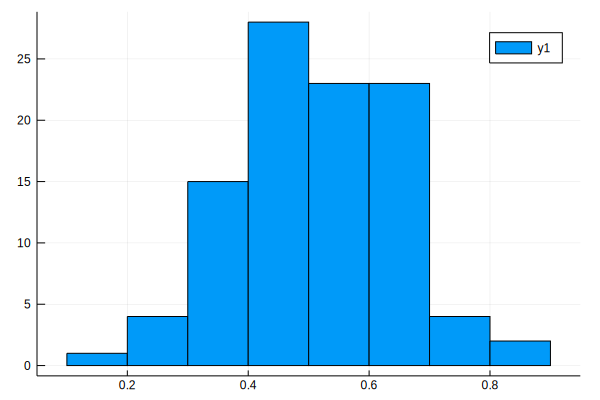

In [7]:
histogram(log.(sol_real[end])[.!isinf.(log.(sol_real[end]))])

In [8]:
function sim(N_sp::Int64,Nsim::Int64,a_min::Float64,a_max::Float64)
    #define parameters
    u0 = ones(N_sp)
    #growth
    u_r = Normal(1,0.1)
    r  = rand(u_r,N_sp)
    #intra
    a_i = ones(N_sp)
    
    result = Array{Float64,3}(undef,500,Nsim,2)
    a_ratio = range(a_min,stop = a_max,length = Nsim)
    t = range(0,stop=100,length = 500)
    
    for i  = 1:Nsim
        #inter
        u_p = Normal(a_ratio[i], 0.1)
        p = rand(u_p,N_sp)
        println(u_p.μ)
        #for real sims
        u_a = Normal(u_p.μ/N_sp,u_p.σ/N_sp)
        a = rand(u_a,N_sp,N_sp)

        P_real = make_params(U,R,a,intra = false)
        P_approx = param = [[mean(r),moment(r,2,0)],[mean(a_i),moment(a_i,2,0)],[mean(p),moment(p,2,0)]]
        
        sol_real = simulate(u0,P_real,t_end = 100.0)
        
        prob = ODEProblem(test_mean_app,[mean(u0)],(0.0,100.0),P_approx)
        sol_mean_app = solve(prob,Rosenbrock23())
        
        result[:,i,1] = mean.(sol_real(t).u)
        result[:,i,2] = hcat(sol_mean_app(t).u...)
        
    end
    
    return(result)

end

    

sim (generic function with 1 method)

0.1
12.575
25.05
37.525
50.0


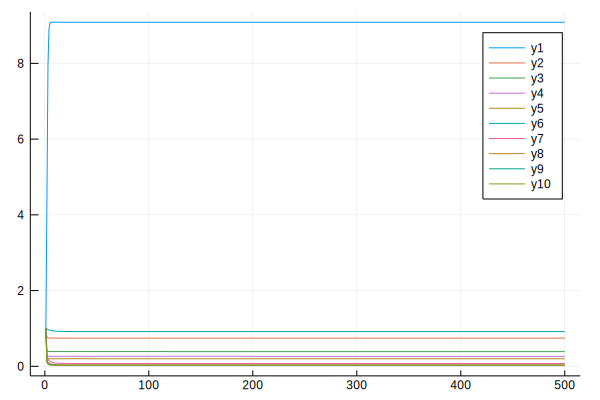

In [9]:
sol = sim(100,5,0.1,50.0)

plot(sol[:,:,1])
plot!(sol[:,:,2])

In [633]:
sol_mean_app(t).u

100-element Array{Array{Float64,1},1}:
 [1.0]     
 [0.842814]
 [0.746777]
 [0.683055]
 [0.638573]
 [0.606244]
 [0.582121]
 [0.563844]
 [0.549741]
 [0.538637]
 [0.529994]
 [0.523039]
 [0.517582]
 ⋮         
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]
 [0.494428]

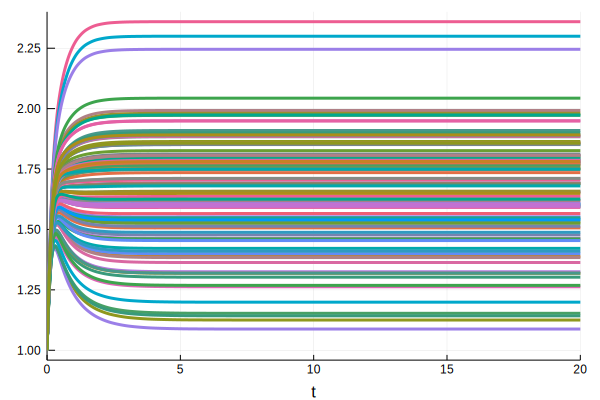

In [11]:
tspan = (0.0,20.0)
function test_mean(du,u,p,t)
    for i=1:length(du)
        du[i] = u[i] *(p[1][i] - p[2][i]*u[i] - p[3][i]*mean(u))
    end
end

prob = ODEProblem(test_mean,u0,tspan,[r,a_i,p])
sol = solve(prob,Rosenbrock23());
plot(sol,legend=false)